In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn import preprocessing
import seaborn as sns
import time
from datetime import date
%matplotlib inline

from collections import Counter

import sklearn.metrics
import matplotlib.patches as patches

from datetime import datetime
from dateutil.parser import parse

import scipy
from scipy import signal,misc,stats

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 10000)

from tqdm import notebook as tqdm
from tqdm import tqdm
for i in tqdm(range(10000)):
    pass

100%|██████████| 10000/10000 [00:00<00:00, 4806674.31it/s]


In [2]:
# Load in datasets
calendar = pd.read_csv('/home/steven/Udacity_Class/Project1_Blog_Post/boston/calendar.csv')
listings = pd.read_csv('/home/steven/Udacity_Class/Project1_Blog_Post/boston/listings.csv')
reviews = pd.read_csv('/home/steven/Udacity_Class/Project1_Blog_Post/boston/reviews.csv')

## Data Clean-up and Restructing

In [3]:
# Change column name to match other dataFrames
listings = listings.rename(columns = {'id':'listing_id'})
calendar = calendar.rename(columns = {'price':'calendar_price'})

In [4]:
calendar_1 = calendar.dropna(subset=['calendar_price'])
# Drop rows that have nan for calendar_price to avoid float error
calendar_1['calendar_price_1'] = calendar_1['calendar_price'].map(lambda p: int(p[1:-3].replace(",", "")))
calendar_1 = calendar_1.drop(columns = ['calendar_price'])
calendar = calendar.merge(calendar_1, how = 'left', left_on=calendar.index, right_on = calendar_1.index)
calendar = calendar.drop(columns = ['key_0', 'listing_id_y', 'date_y', 'available_y'])
calendar = calendar.drop(columns = ['calendar_price'])
calendar = calendar.rename(columns = {'listing_id_x':'listing_id', 'date_x':'date', 'available_x':'available', 'calendar_price_1':'calendar_price'})

/home/steven/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [5]:
# Merge two dataFrames
boston = calendar.merge(listings, on=['listing_id'])

In [6]:
# Drop columns that contain URLs
boston = boston[boston.columns.drop(list(boston.filter(regex = 'url')))]

In [7]:
# Check number of NaNs in columns
boston.isna().sum().sort_values(ascending=False)

has_availability                    1308890
neighbourhood_group_cleansed        1308890
jurisdiction_names                  1308890
license                             1308890
square_feet                         1288450
monthly_price                        984770
weekly_price                         983310
security_deposit                     819060
notes                                720875
calendar_price                       665853
interaction                          567575
access                               543850
neighborhood_overview                516840
host_about                           477785
transit                              471215
house_rules                          435080
cleaning_fee                         404420
space                                386170
review_scores_accuracy               300760
review_scores_location               300395
review_scores_value                  300030
review_scores_checkin                299665
review_scores_cleanliness       

In [8]:
# Drop columns that contain only NaN values
boston = boston.drop(columns = ['has_availability', 'neighbourhood_group_cleansed', 'jurisdiction_names','license','square_feet'])

In [9]:
# The next few lines, checking score scaling
boston['review_scores_rating'][boston['review_scores_rating'].isna()!=True]

365        94.0
366        94.0
367        94.0
368        94.0
369        94.0
           ... 
1308520    90.0
1308521    90.0
1308522    90.0
1308523    90.0
1308524    90.0
Name: review_scores_rating, Length: 1011780, dtype: float64

In [10]:
boston['review_scores_accuracy'][boston['review_scores_accuracy'].isna()!=True]

365        10.0
366        10.0
367        10.0
368        10.0
369        10.0
           ... 
1308520     9.0
1308521     9.0
1308522     9.0
1308523     9.0
1308524     9.0
Name: review_scores_accuracy, Length: 1008130, dtype: float64

In [11]:
boston['review_scores_location'][boston['review_scores_location'].isna()!=True]

365        9.0
366        9.0
367        9.0
368        9.0
369        9.0
          ... 
1308520    8.0
1308521    8.0
1308522    8.0
1308523    8.0
1308524    8.0
Name: review_scores_location, Length: 1008495, dtype: float64

In [12]:
boston['review_scores_value'][boston['review_scores_value'].isna()!=True]

365        9.0
366        9.0
367        9.0
368        9.0
369        9.0
          ... 
1308520    7.0
1308521    7.0
1308522    7.0
1308523    7.0
1308524    7.0
Name: review_scores_value, Length: 1008860, dtype: float64

In [13]:
boston['review_scores_checkin'][boston['review_scores_checkin'].isna()!=True]

365        10.0
366        10.0
367        10.0
368        10.0
369        10.0
           ... 
1308520     9.0
1308521     9.0
1308522     9.0
1308523     9.0
1308524     9.0
Name: review_scores_checkin, Length: 1009225, dtype: float64

In [14]:
boston['review_scores_cleanliness'][boston['review_scores_cleanliness'].isna()!=True]

365        9.0
366        9.0
367        9.0
368        9.0
369        9.0
          ... 
1308520    8.0
1308521    8.0
1308522    8.0
1308523    8.0
1308524    8.0
Name: review_scores_cleanliness, Length: 1009955, dtype: float64

In [15]:
boston['review_scores_communication'][boston['review_scores_communication'].isna()!=True]

365        10.0
366        10.0
367        10.0
368        10.0
369        10.0
           ... 
1308520     9.0
1308521     9.0
1308522     9.0
1308523     9.0
1308524     9.0
Name: review_scores_communication, Length: 1009955, dtype: float64

In [16]:
# Changing scale of this rating to match the other rating columns
boston['review_scores_rating'] = boston['review_scores_rating']/10

### Check count and distribution of ratings

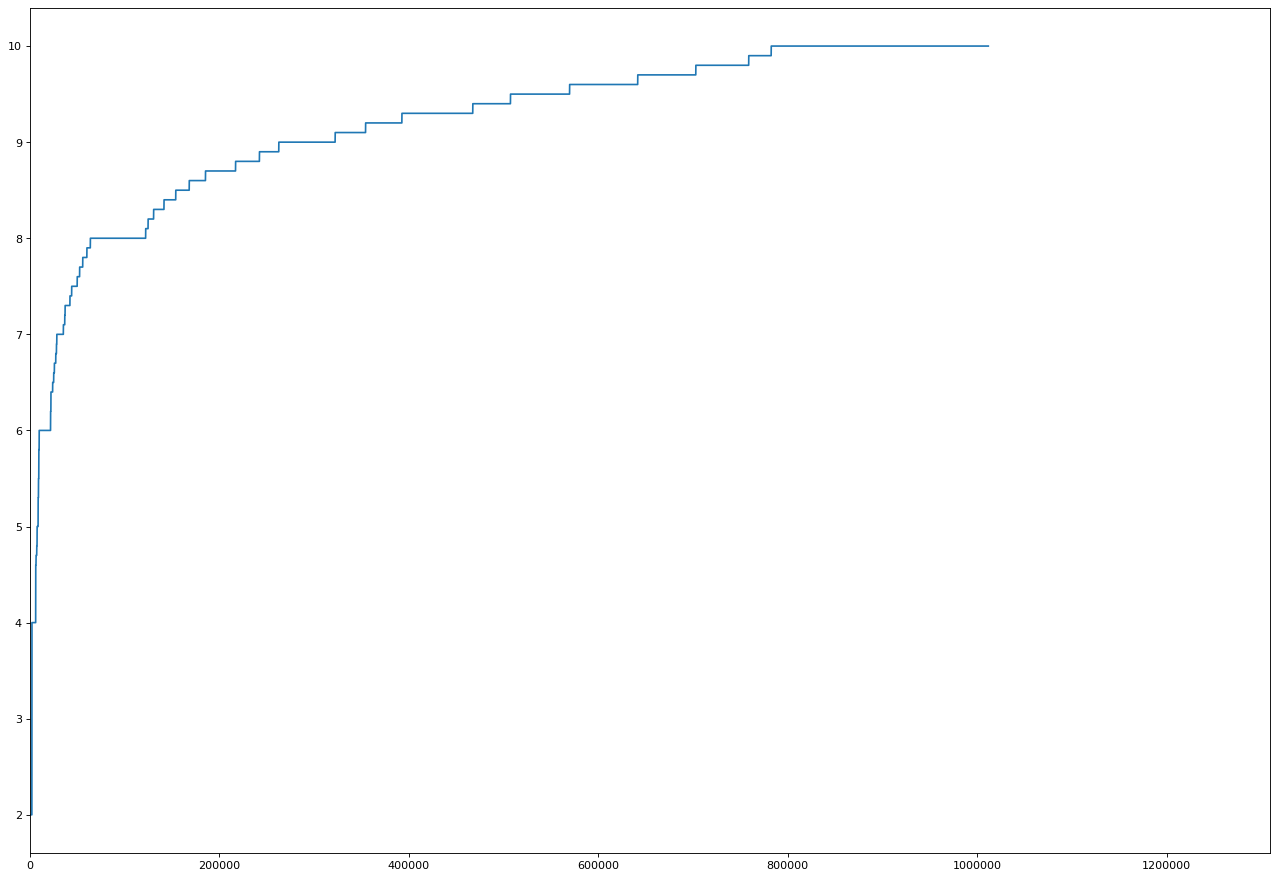

In [17]:
fig = plt.figure(figsize=(20, 14), dpi=80)
boston['review_scores_rating'].sort_values().reset_index(drop=True).plot()

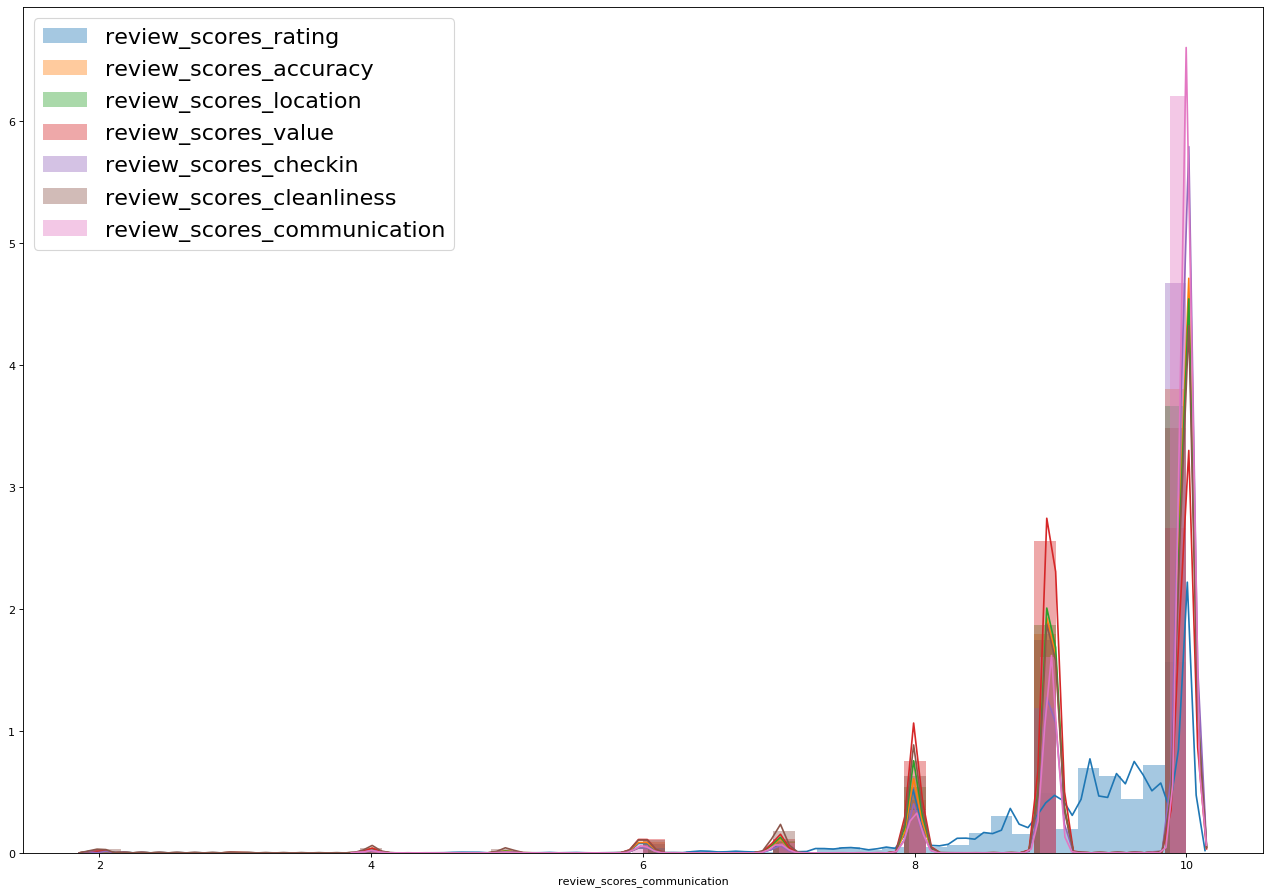

In [18]:
# Check the distribrution of scorings, dropping nans just for visiualization. 

fig = plt.figure(figsize=(20, 14), dpi=80)
sns.distplot(boston['review_scores_rating'].dropna(), label = 'review_scores_rating')
sns.distplot(boston['review_scores_accuracy'].dropna(), label = 'review_scores_accuracy')
sns.distplot(boston['review_scores_location'].dropna(), label = 'review_scores_location')
sns.distplot(boston['review_scores_value'].dropna(), label = 'review_scores_value')
sns.distplot(boston['review_scores_checkin'].dropna(), label = 'review_scores_checkin')
sns.distplot(boston['review_scores_cleanliness'].dropna(), label = 'review_scores_cleanliness')
sns.distplot(boston['review_scores_communication'].dropna(), label = 'review_scores_communication')
plt.legend(fontsize=20);

### We can see that all reviews seem to trend the same way, with most reviews being 8 or above. 

## Which words correlate most in descriptions and reviews

In [19]:
boston['summary'][0]

'Cozy, sunny, family home.  Master bedroom high ceilings. Deck, garden with hens, beehives & play structure.   Short walk to charming village with  attractive stores, groceries & local restaurants. Friendly neighborhood. Access public transportation.'

In [20]:
def word_count(df, column):
    """ Split row into individual words, make on long string, and return dataframe with most common words"""
    summary = []
    for row in tqdm(df[column].unique()):
        summary.append(row)
    def concatenate_list_data(list):
        """Return list of individual words in row"""
        result= ''
        for element in list:
            result += str(element)
        return result

    summary = concatenate_list_data(summary)
    summary = summary.lower()

    split_it = summary.split()
    counter = Counter(split_it)
    most_occur = counter.most_common(150)
    return(most_occur)


In [21]:
# Find count of words used in boston['summary']

most_occur = word_count(boston, 'summary')
description = pd.DataFrame(most_occur, columns = ['word', 'count'])

100%|██████████| 3114/3114 [00:00<00:00, 2523876.84it/s]


In [22]:
# Most common words in English

wordlist = ('the','of','to','and','a','in','is','it','you','that','he','was','for','on','are','with','as','I','his',
'they','be','at','one','have','this','from','or','had','by','not','word','but','what','some','we','can','out',
'other','were','all','there','when','up','use','your','how','said','an','each','she','which','do','their','time',
'if','will','way','about','many','then','them','write','would','like','so','these','her','long','make','thing',
'see','him','two','has','look','more','day','could','go','come','did','number','sound','no','most','people','my',
'over','know','water','than','call','first','who','may','down','side','been','now','find', '1', '2', '3', '4','5',
           '6', '7', '8', '9', '0', '&', '-', 't', 'i', 'kitchen,', 'restaurants,', 'couples,', "boston's")

In [23]:
# Checking which words in the summary match the words in the list to drop those words

description_most_common = description[~description.word.isin(wordlist)]
description_most_common = description_most_common.reset_index()
description_most_common.drop(columns = ['index']);

No handles with labels found to put in legend.


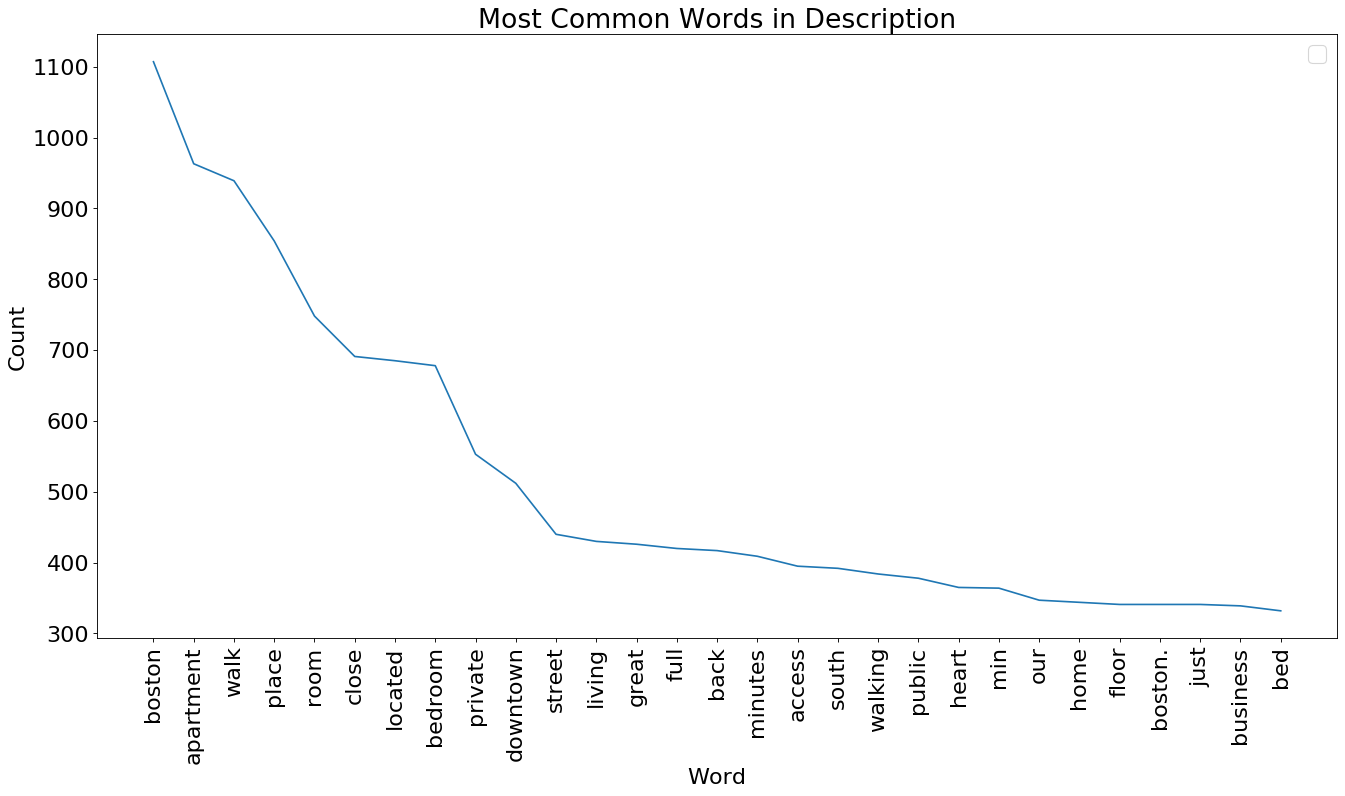

In [24]:
# Plot the most common words from the summary and their count

fig = plt.figure(figsize=(20, 10), dpi=80)
plt.plot(description_most_common['word'][:29], description_most_common['count'][:29])
plt.xlabel('Word', fontsize = 20)
plt.ylabel('Count', fontsize = 20)
plt.tick_params(axis='x', labelsize=20, labelrotation=90)
plt.tick_params(axis='y', labelsize=20)
plt.legend(fontsize = 20)
plt.title('Most Common Words in Description', fontsize = 24);

In [25]:
reviews['comments'][0]

"My stay at islam's place was really cool! Good location, 5min away from subway, then 10min from downtown. The room was nice, all place was clean. Islam managed pretty well our arrival, even if it was last minute ;) i do recommand this place to any airbnb user :)"

In [26]:
# Do the same comments in reviews dataframe

most_common = word_count(reviews, 'comments')
review_words = pd.DataFrame(most_occur, columns = ['word', 'count'])

100%|██████████| 67312/67312 [00:00<00:00, 2794680.33it/s]


In [27]:
reviews_most_common = review_words[~review_words.word.isin(wordlist)]
reviews_most_common = reviews_most_common.reset_index()
reviews_most_common = reviews_most_common.drop(columns = ['index']);

No handles with labels found to put in legend.


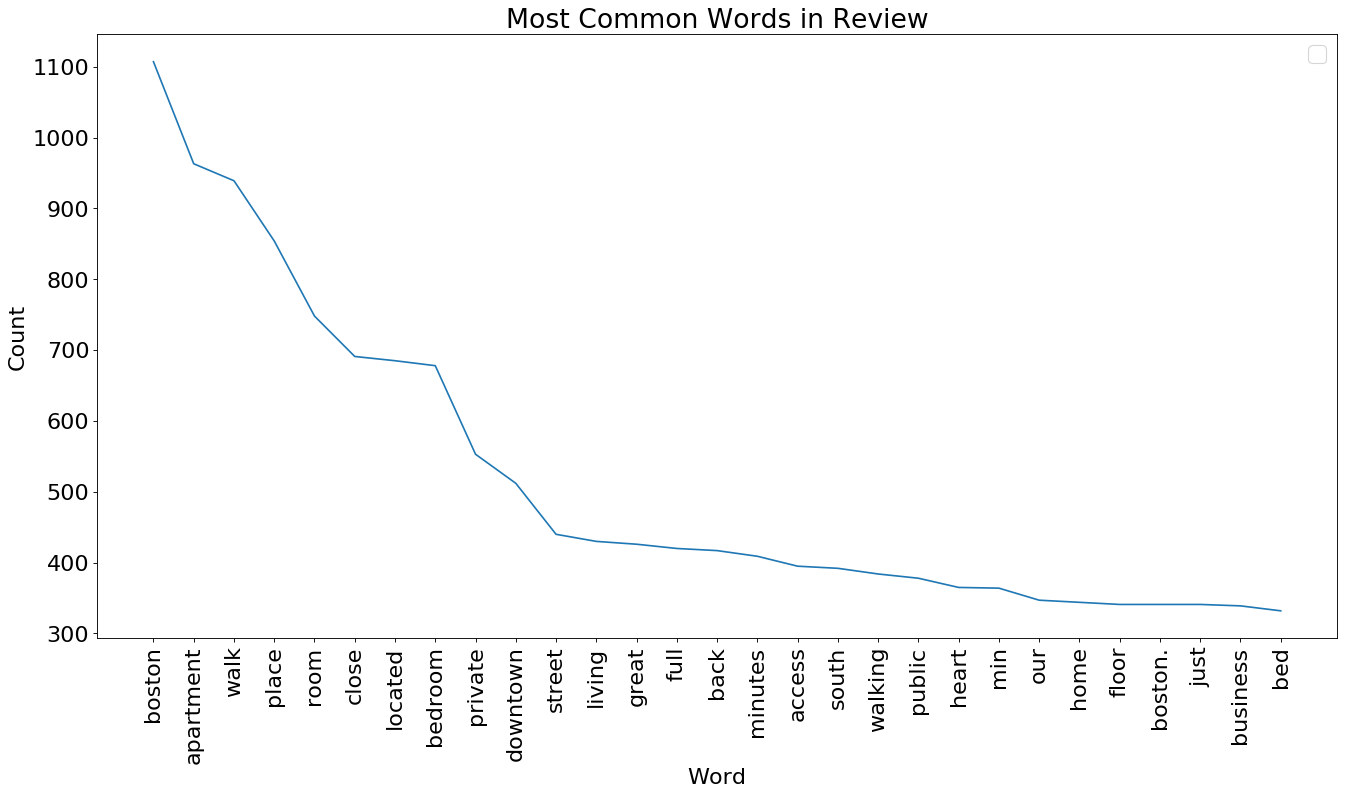

In [28]:
fig = plt.figure(figsize=(20, 10), dpi=80)
plt.plot(reviews_most_common['word'][:29], reviews_most_common['count'][:29])
plt.xlabel('Word', fontsize = 20)
plt.ylabel('Count', fontsize = 20)
plt.tick_params(axis='x', labelsize=20, labelrotation=90)
plt.tick_params(axis='y', labelsize=20)
plt.legend(fontsize = 20)
plt.title('Most Common Words in Review', fontsize = 24);

In [29]:
#Compare the two word lists against one another

most_common = description_most_common[description_most_common.word.isin(reviews_most_common.word)]
most_common = most_common.merge(reviews_most_common, on = 'word', suffixes=("_desc", "_review"))
most_common['total'] = most_common['count_desc']+ most_common['count_review']
most_common = most_common.reset_index()
most_common = most_common.drop(columns = ['index'])
most_common = most_common.drop(columns = ['level_0']);
most_common = most_common[:29]
most_common['prop'] = most_common['total']/(most_common['total'].sum())
most_common = most_common.sort_values(by = 'prop', ascending = False)

No handles with labels found to put in legend.


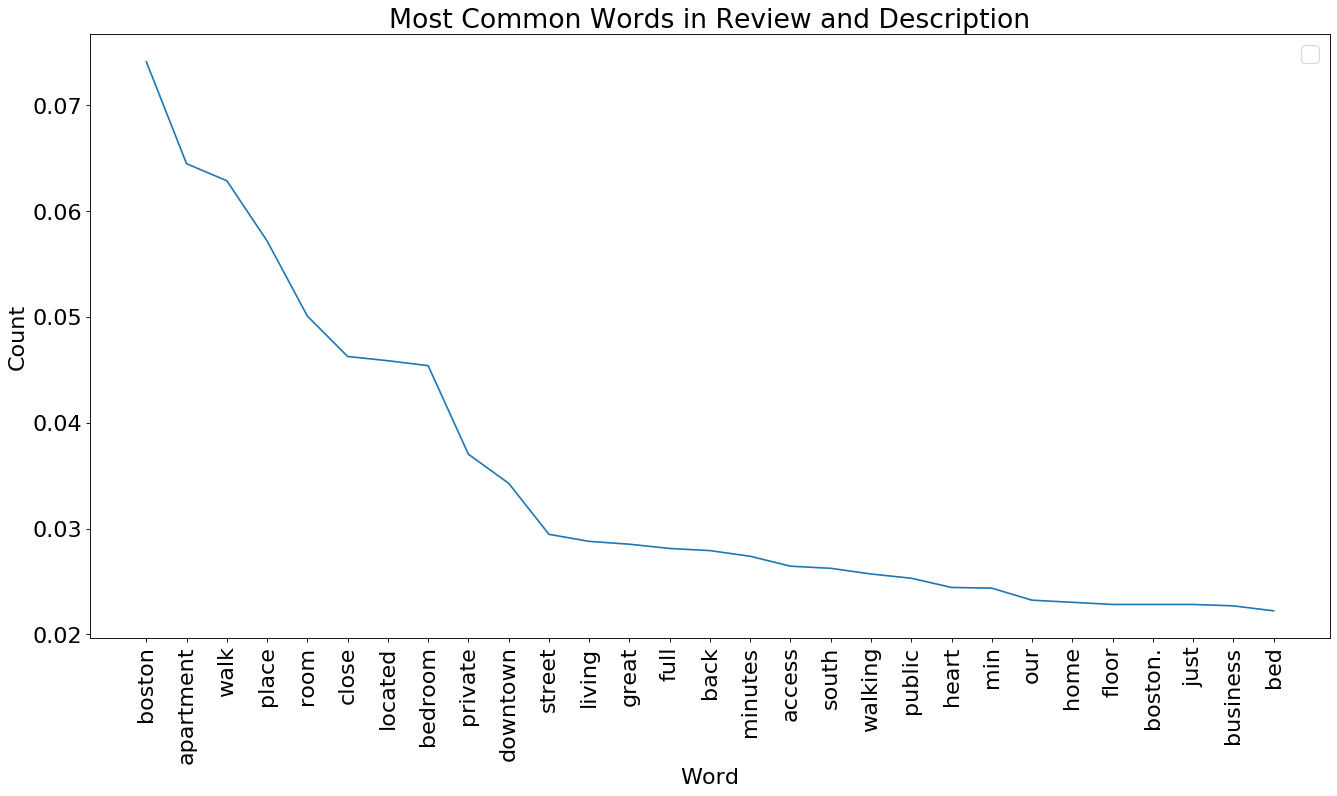

In [30]:
# Most common words that occur in both listings and comments

fig = plt.figure(figsize=(20, 10), dpi=80)
plt.plot(most_common['word'][:29], most_common['prop'])
plt.xlabel('Word', fontsize = 20)
plt.ylabel('Count', fontsize = 20)
plt.tick_params(axis='x', labelsize=20, labelrotation=90)
plt.tick_params(axis='y', labelsize=20)
plt.legend(fontsize = 20)
plt.title('Most Common Words in Review and Description', fontsize = 24);

## How Do Prices Change with Various Features
Features to look at:
- Neighborhood
- Whether the host is superhost or not
- Property Type
- Room Type
- Bed Type
- Number of Beds
- Time of Year

In [31]:
boston['calendar_price'].describe()

count    643037.000000
mean        198.438909
std         180.142913
min          11.000000
25%          85.000000
50%         150.000000
75%         255.000000
max        7163.000000
Name: calendar_price, dtype: float64

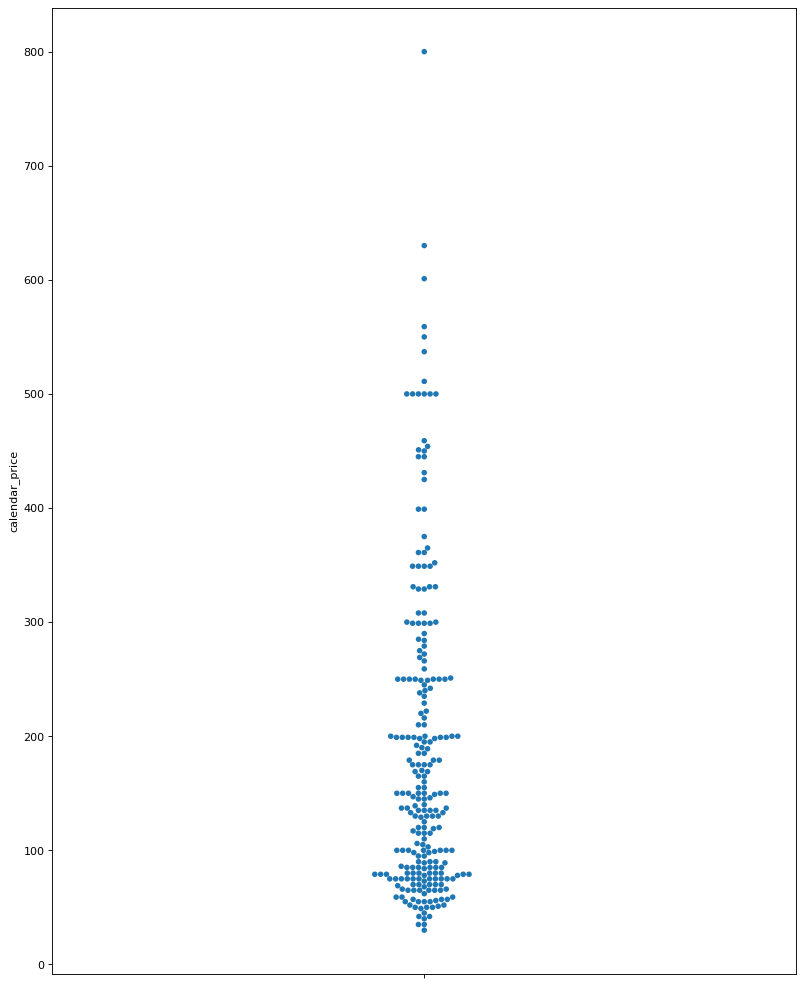

In [32]:
fig = plt.figure(figsize=(12, 16), dpi=80)
sns.swarmplot(y=boston['calendar_price'].sample(500))

In [33]:
# First part to get a sort list that gets a descending order of median calendar_price
def median_sort_order(df, sort_column, func_column, new_df_column_1, new_df_column_2):
    """Finds median price of each neighborhood and returns sort order based on that price"""
    order = [0,0]
    for x in tqdm(df[sort_column].unique()):
        df_1 = df[df[sort_column] == x]
        median = df_1[func_column].median()
        row = [x, median]
        row = np.array(row)
        order = np.vstack([order, row])
    order = pd.DataFrame(order, columns = [new_df_column_1, new_df_column_2])
    order[new_df_column_2] = order[new_df_column_2].astype(float)
    order = order.drop(order.index[0])
    order = order.sort_values(by = new_df_column_2, ascending = False)
    sort_order = list(order[new_df_column_1])
    return sort_order

100%|██████████| 25/25 [00:01<00:00, 16.11it/s]
No handles with labels found to put in legend.


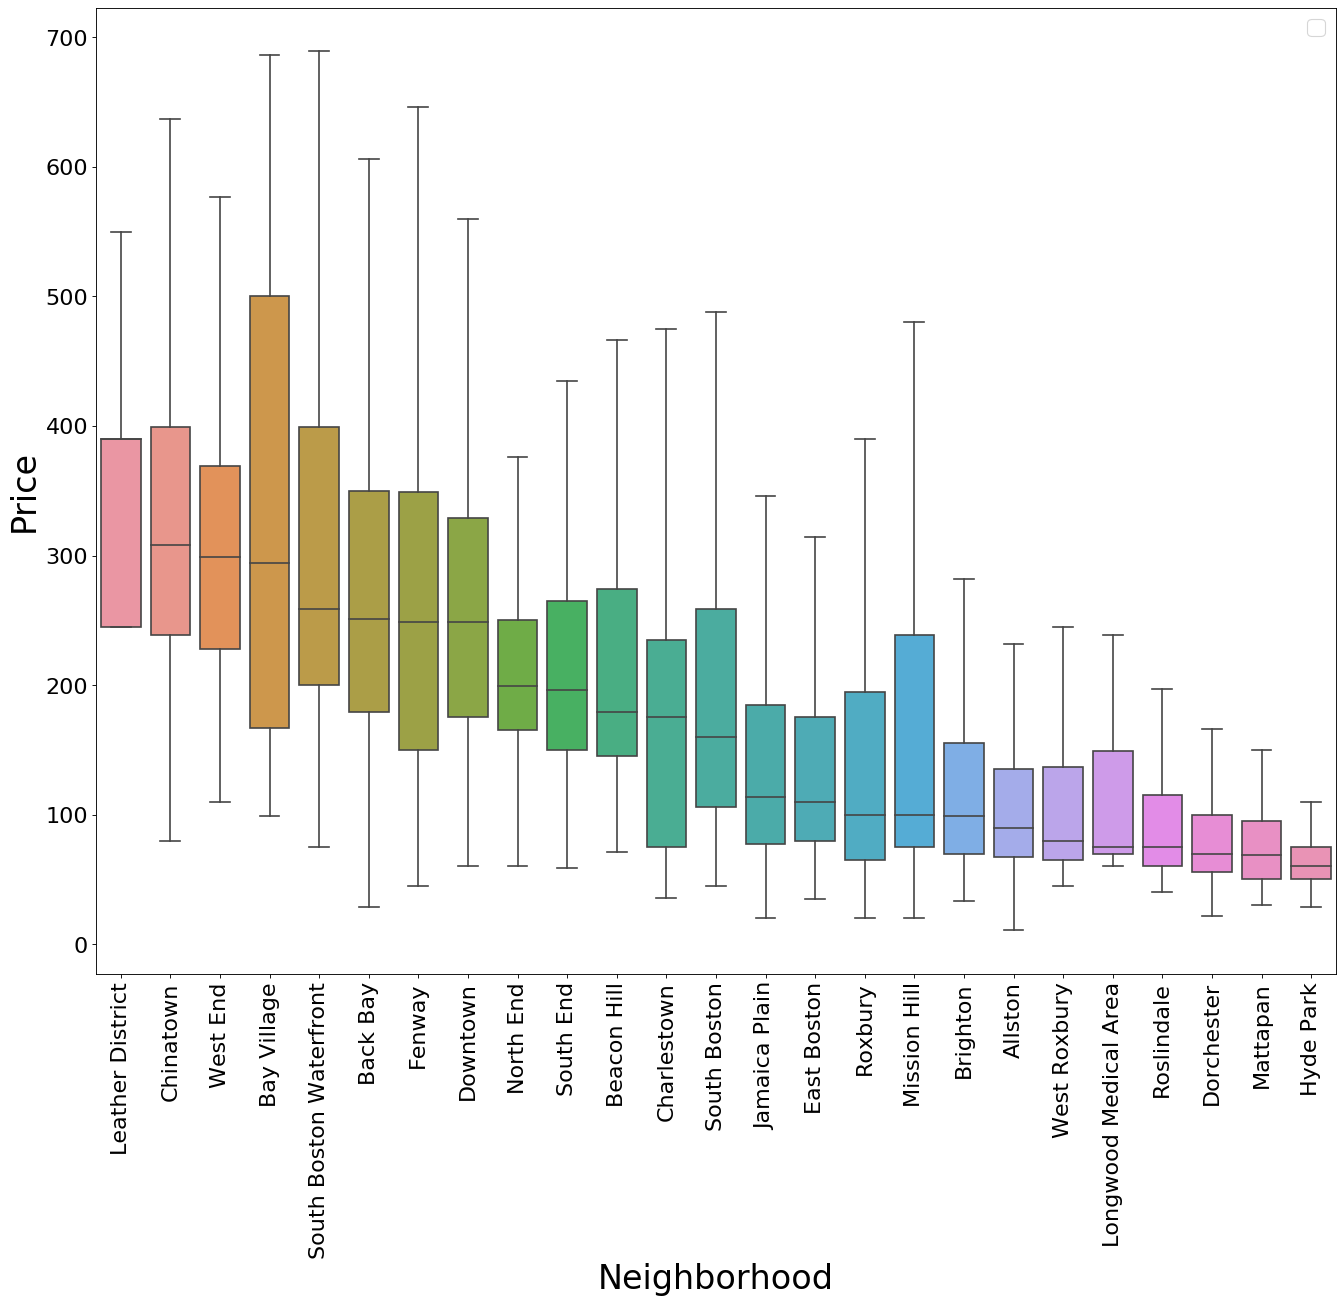

In [34]:
# Compare calendar_prices to the neighborhoods they occur in

sort_order = median_sort_order(boston, 'neighbourhood_cleansed', 'calendar_price', 'neighborhood', 'median_calendar_price')

fig = plt.figure(figsize=(20, 16), dpi=80)
sns.boxplot(x = 'neighbourhood_cleansed', y = 'calendar_price', data = boston, showfliers = False, order = sort_order)
plt.ylabel('Price', fontsize=30)
plt.xlabel('Neighborhood', fontsize=30)
plt.tick_params(axis='x', labelsize=20, rotation=90)
plt.tick_params(axis='y', labelsize=20)
plt.legend(fontsize=20);

In [35]:
df = boston

    
# Gettin summary statistics
stats.f_oneway(df['calendar_price'][df['neighbourhood_cleansed'] == 'Roslindale'], 
             df['calendar_price'][df['neighbourhood_cleansed'] == 'Jamaica Plain'],
              df['calendar_price'][df['neighbourhood_cleansed'] == 'Mission Hill'],
              df['calendar_price'][df['neighbourhood_cleansed'] == 'Longwood Medical Area'],
              df['calendar_price'][df['neighbourhood_cleansed'] == 'Bay Village'],
              df['calendar_price'][df['neighbourhood_cleansed'] == 'Leather District'],
              df['calendar_price'][df['neighbourhood_cleansed'] == 'Chinatown'],
              df['calendar_price'][df['neighbourhood_cleansed'] == 'North End'],
              df['calendar_price'][df['neighbourhood_cleansed'] == 'Roxbury'],
              df['calendar_price'][df['neighbourhood_cleansed'] == 'South End'],
              df['calendar_price'][df['neighbourhood_cleansed'] == 'Back Bay'],
              df['calendar_price'][df['neighbourhood_cleansed'] == 'East Boston'],
              df['calendar_price'][df['neighbourhood_cleansed'] == 'Charlestown'],
              df['calendar_price'][df['neighbourhood_cleansed'] == 'West End'],
              df['calendar_price'][df['neighbourhood_cleansed'] == 'Beacon Hill'],
              df['calendar_price'][df['neighbourhood_cleansed'] == 'Downtown'],
              df['calendar_price'][df['neighbourhood_cleansed'] == 'Fenway'],
              df['calendar_price'][df['neighbourhood_cleansed'] == 'Brighton'],
              df['calendar_price'][df['neighbourhood_cleansed'] == 'West Roxbury'],
              df['calendar_price'][df['neighbourhood_cleansed'] == 'Hyde Park'],
              df['calendar_price'][df['neighbourhood_cleansed'] == 'Mattapan'],
              df['calendar_price'][df['neighbourhood_cleansed'] == 'Dorchester'],
              df['calendar_price'][df['neighbourhood_cleansed'] == 'South Boston Waterfront'],
              df['calendar_price'][df['neighbourhood_cleansed'] == 'South Boston'],
              df['calendar_price'][df['neighbourhood_cleansed'] == 'Allston'])

F_onewayResult(statistic=nan, pvalue=nan)

No handles with labels found to put in legend.


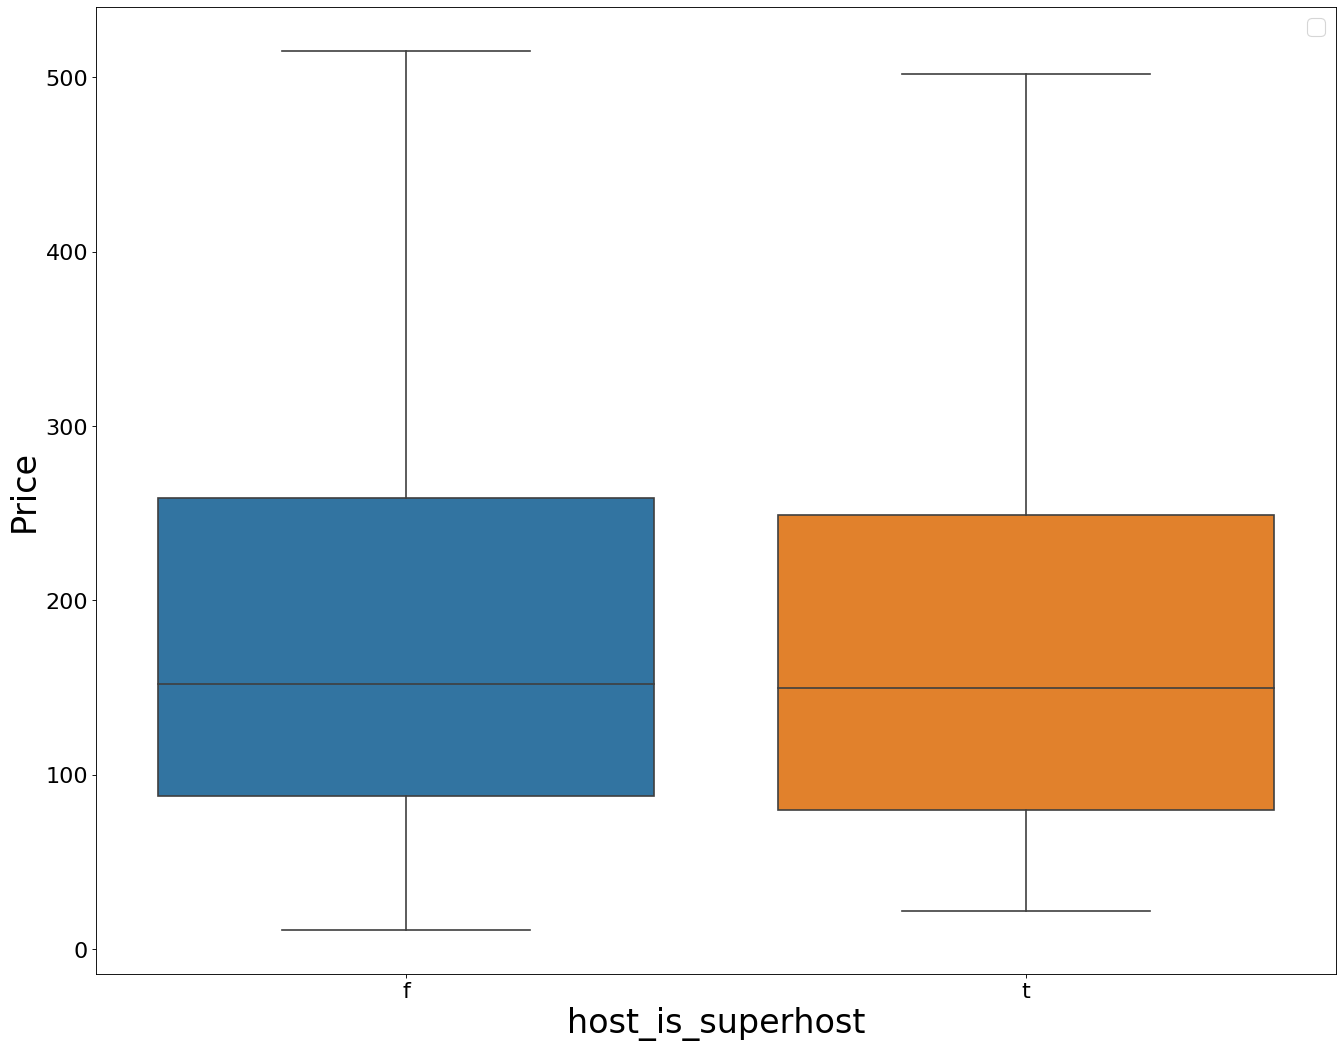

In [36]:
fig = plt.figure(figsize=(20, 16), dpi=80)
sns.boxplot(y='calendar_price', x='host_is_superhost', data=boston, showfliers = False)
plt.ylabel('Price', fontsize=30)
plt.xlabel('host_is_superhost', fontsize=30)
plt.tick_params(axis='x', labelsize=20)
plt.tick_params(axis='y', labelsize=20)
plt.legend(fontsize=20)

### Check distribution of prices to decide which statistical test to use

Text(0.5, 1.0, 'Price per Superhost Designation')

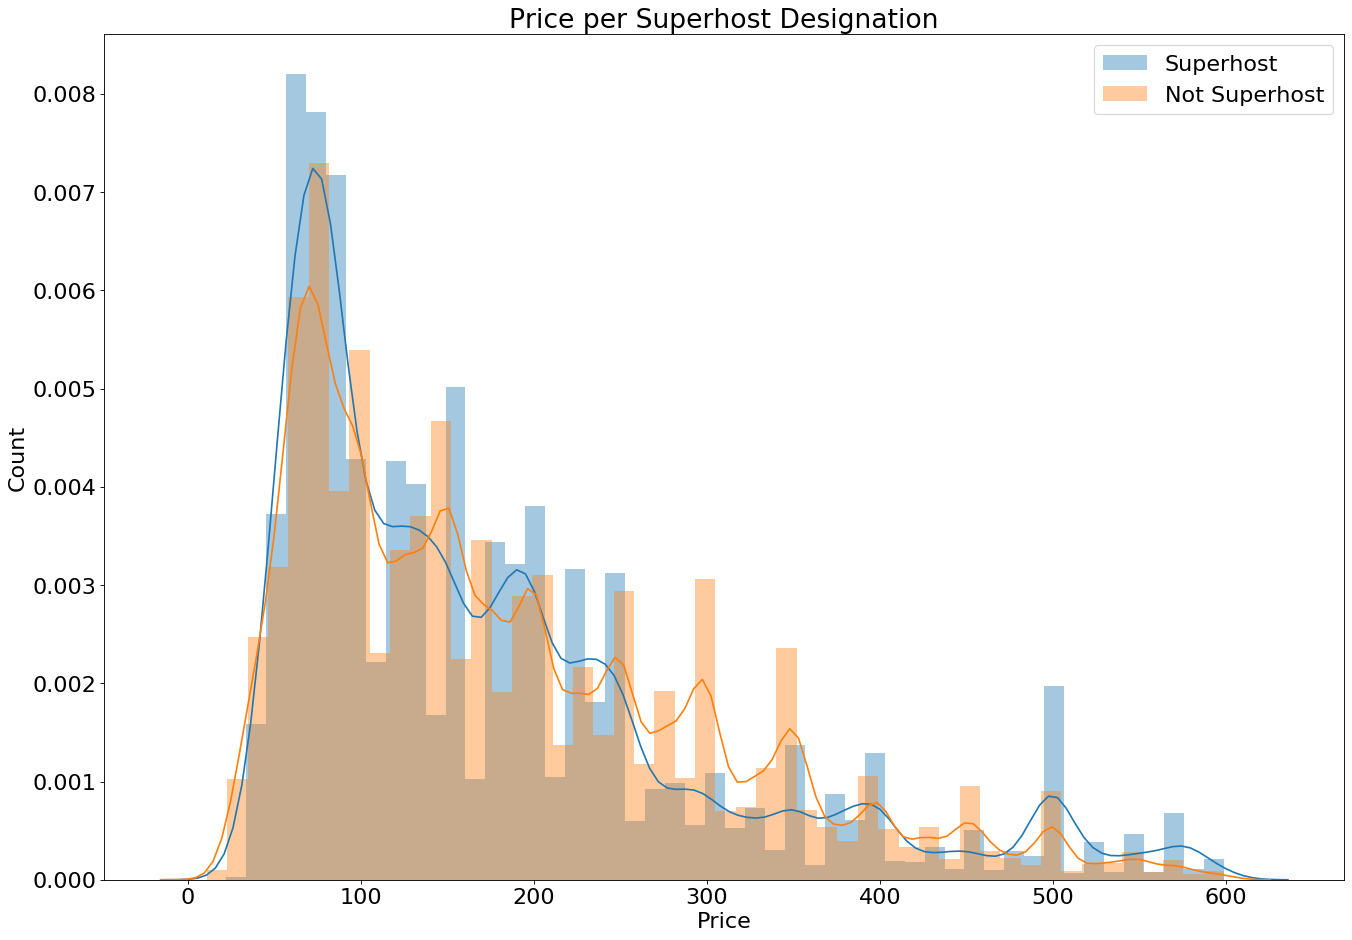

In [37]:
fig = plt.figure(figsize=(20, 14), dpi=80)
sns.distplot(boston['calendar_price'][(boston['host_is_superhost']=='t') & (boston['calendar_price']<600)], label='Superhost')
sns.distplot(boston['calendar_price'][(boston['host_is_superhost']=='f') & (boston['calendar_price']<600)], label = 'Not Superhost')
plt.xlabel('Price', fontsize = 20)
plt.ylabel('Count', fontsize = 20)
plt.tick_params(axis='x', labelsize=20)
plt.tick_params(axis='y', labelsize=20)
plt.legend(fontsize = 20)
plt.title('Price per Superhost Designation', fontsize = 24)

In [38]:
df = boston
x = df['calendar_price'][df['host_is_superhost'] == 't']
y = df['calendar_price'][df['host_is_superhost'] == 'f']
scipy.stats.mannwhitneyu(x, y, use_continuity=True, alternative=None)

MannwhitneyuResult(statistic=83061517006.0, pvalue=2.711012608181131e-115)

100%|██████████| 14/14 [00:01<00:00, 11.43it/s]
No handles with labels found to put in legend.


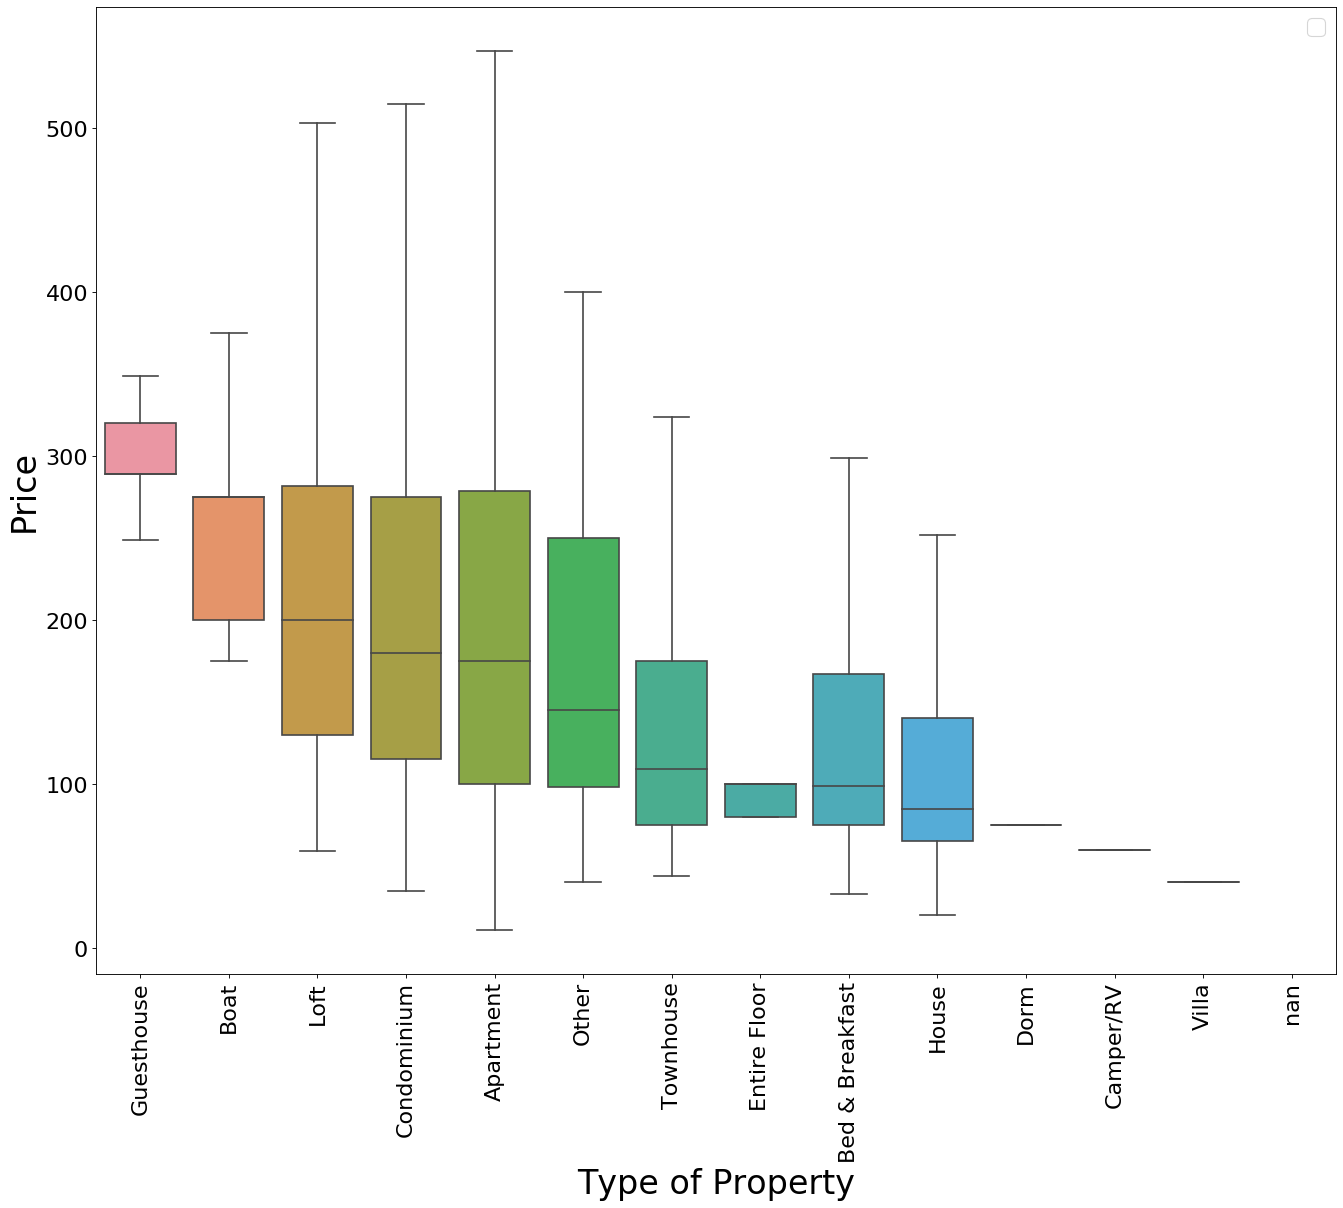

In [39]:
# Compare calendar_prices to the property types

sort_order = median_sort_order(boston, 'property_type', 'calendar_price', 'property_type', 'median_calendar_price')

fig = plt.figure(figsize=(20, 16), dpi=80)
sns.boxplot(x = 'property_type', y = 'calendar_price', data = boston, showfliers = False, order = sort_order)
plt.ylabel('Price', fontsize=30)
plt.xlabel('Type of Property', fontsize=30)
plt.tick_params(axis='x', labelsize=20, rotation=90)
plt.tick_params(axis='y', labelsize=20)
plt.legend(fontsize=20);

In [40]:
df = boston

    
# Gettin summary statistics
stats.f_oneway(df['calendar_price'][df['property_type'] == 'House'], 
             df['calendar_price'][df['property_type'] == 'Apartment'],
              df['calendar_price'][df['property_type'] == 'Condominium'],
              df['calendar_price'][df['property_type'] == 'Villa'],
              df['calendar_price'][df['property_type'] == 'Bed & Breakfast'],
              df['calendar_price'][df['property_type'] == 'Townhouse'],
              df['calendar_price'][df['property_type'] == 'Entire Floor'],
              df['calendar_price'][df['property_type'] == 'Loft'],
              df['calendar_price'][df['property_type'] == 'Guesthouse'],
              df['calendar_price'][df['property_type'] == 'Boat'],
              df['calendar_price'][df['property_type'] == 'Dorm'],
              df['calendar_price'][df['property_type'] == 'Other'],
              df['calendar_price'][df['property_type'] == 'Camper/RV'])

F_onewayResult(statistic=nan, pvalue=nan)

100%|██████████| 3/3 [00:00<00:00,  3.75it/s]
No handles with labels found to put in legend.


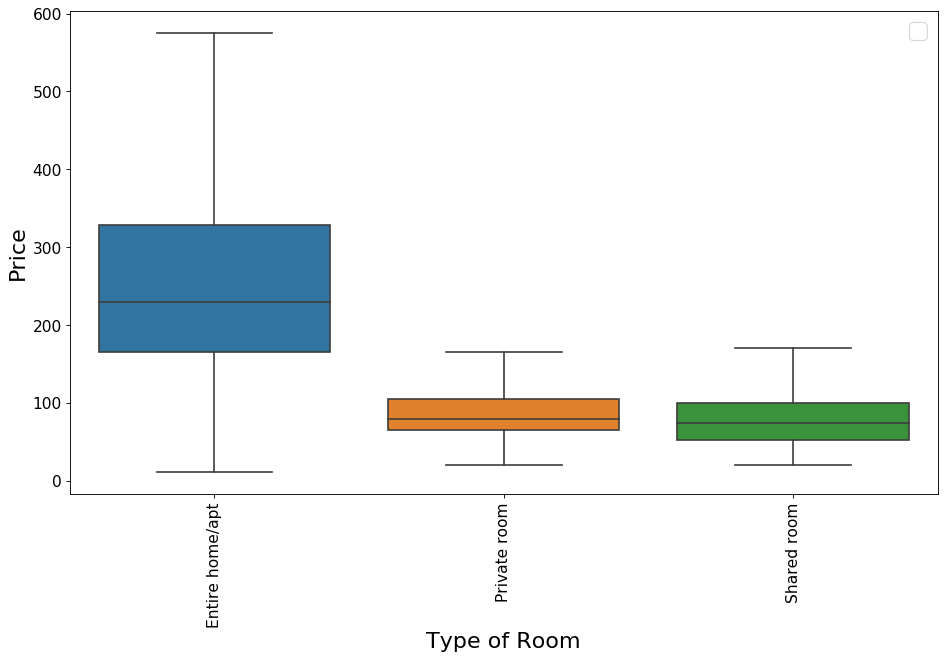

In [41]:
# Compare calendar_prices to the room types

sort_order = median_sort_order(boston, 'room_type', 'calendar_price', 'room_type', 'median_calendar_price')

fig = plt.figure(figsize=(14, 8), dpi=80)
sns.boxplot(x = 'room_type', y = 'calendar_price', data = boston, showfliers = False, order = sort_order)
plt.ylabel('Price', fontsize=20)
plt.xlabel('Type of Room', fontsize=20)
plt.tick_params(axis='x', labelsize=14, rotation=90)
plt.tick_params(axis='y', labelsize=14)
plt.legend(fontsize=20);

In [42]:
df = boston

    
# Gettin summary statistics
stats.f_oneway(df['calendar_price'][df['room_type'] == 'Entire home/apt'], 
             df['calendar_price'][df['room_type'] == 'Private room'],
              df['calendar_price'][df['room_type'] == 'Shared room'])

F_onewayResult(statistic=nan, pvalue=nan)

100%|██████████| 5/5 [00:00<00:00,  5.90it/s]
No handles with labels found to put in legend.


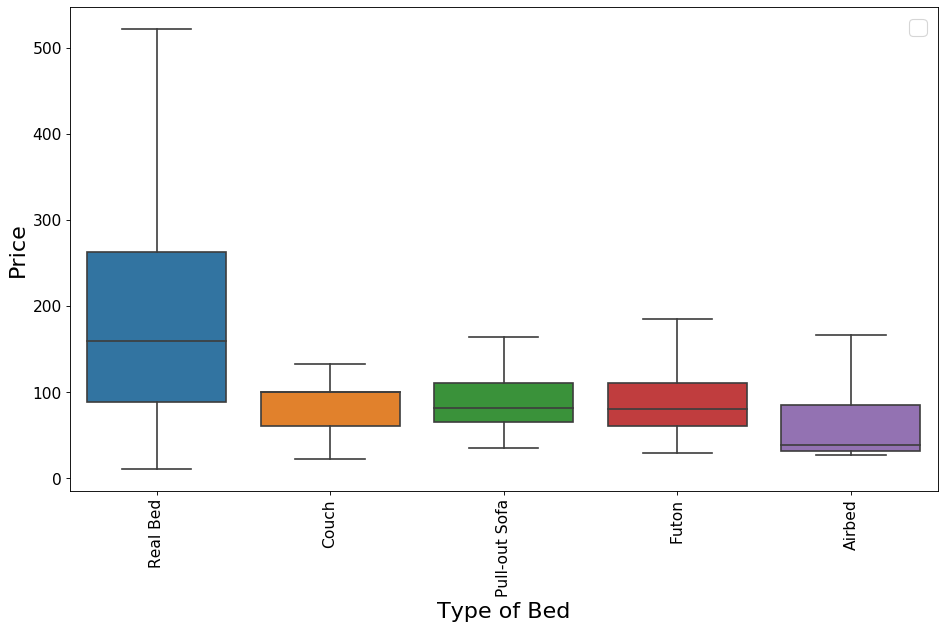

In [43]:
# Compare calendar_prices to the bed types

sort_order = median_sort_order(boston, 'bed_type', 'calendar_price', 'bed_type', 'median_calendar_price')

fig = plt.figure(figsize=(14, 8), dpi=80)
sns.boxplot(x = 'bed_type', y = 'calendar_price', data = boston, showfliers = False, order = sort_order)
plt.ylabel('Price', fontsize=20)
plt.xlabel('Type of Bed', fontsize=20)
plt.tick_params(axis='x', labelsize=14, rotation=90)
plt.tick_params(axis='y', labelsize=14)
plt.legend(fontsize=20);

In [44]:
df = boston

    
# Gettin summary statistics
stats.f_oneway(df['calendar_price'][df['bed_type'] == 'Real Bed'], 
             df['calendar_price'][df['bed_type'] == 'Couch'],
              df['calendar_price'][df['bed_type'] == 'Pull-out Sofa'],
              df['calendar_price'][df['bed_type'] == 'Futon'],
              df['calendar_price'][df['bed_type'] == 'Airbed'])

F_onewayResult(statistic=nan, pvalue=nan)

No handles with labels found to put in legend.


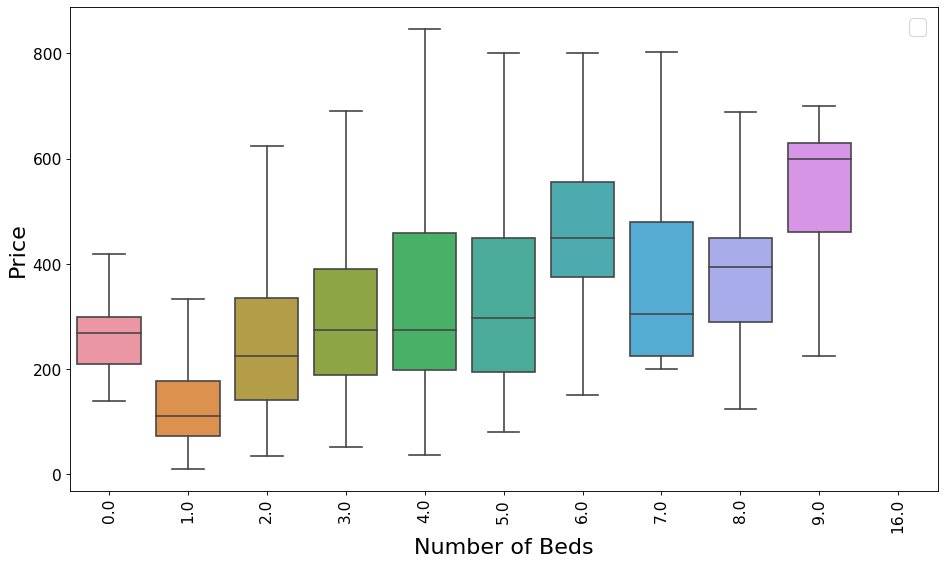

In [45]:
# Compare calendar_prices to the number of beds

# First part to get a sort list that gets a descending order of median calendar_price
fig = plt.figure(figsize=(14, 8), dpi=80)
sns.boxplot(x = 'beds', y = 'calendar_price', data = boston, showfliers = False)
plt.ylabel('Price', fontsize=20)
plt.xlabel('Number of Beds', fontsize=20)
plt.tick_params(axis='x', labelsize=14, rotation=90)
plt.tick_params(axis='y', labelsize=14)
plt.legend(fontsize=20);

In [46]:
df = boston

    
# Gettin summary statistics
stats.f_oneway(df['calendar_price'][df['beds'] == 0.0], 
             df['calendar_price'][df['beds'] == 1.0],
              df['calendar_price'][df['beds'] == 2.0],
              df['calendar_price'][df['beds'] == 3.0],
              df['calendar_price'][df['beds'] == 4.0],
              df['calendar_price'][df['beds'] == 5.0],
              df['calendar_price'][df['beds'] == 6.0],
              df['calendar_price'][df['beds'] == 7.0],
              df['calendar_price'][df['beds'] == 8.0],
              df['calendar_price'][df['beds'] == 9.0],
              df['calendar_price'][df['beds'] == 16.0])

F_onewayResult(statistic=nan, pvalue=nan)

In [47]:
# Change date data to datetime

boston['date'] = [datetime.strptime(x, '%Y-%m-%d') for x in boston['date']]

In [48]:
# Grouping data based on neighborhood and taking the mean of the data to see how price changes throughout the year

grouped = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
for hood in tqdm(boston['neighbourhood_cleansed'].unique()):
    b = boston[boston['neighbourhood_cleansed'] == hood]    
    b.index = pd.to_datetime(b['date'],format='%y-%m-%d')
    g = b.groupby(by=b.index.month).mean()
    g['neighborhood'] = hood
    g['date'] = g.index
    h = np.array(g)
    grouped = np.vstack([grouped, h])
grouped = pd.DataFrame(grouped, columns = g.columns)
grouped = grouped.drop(grouped.index[0])

100%|██████████| 25/25 [00:01<00:00, 13.70it/s]


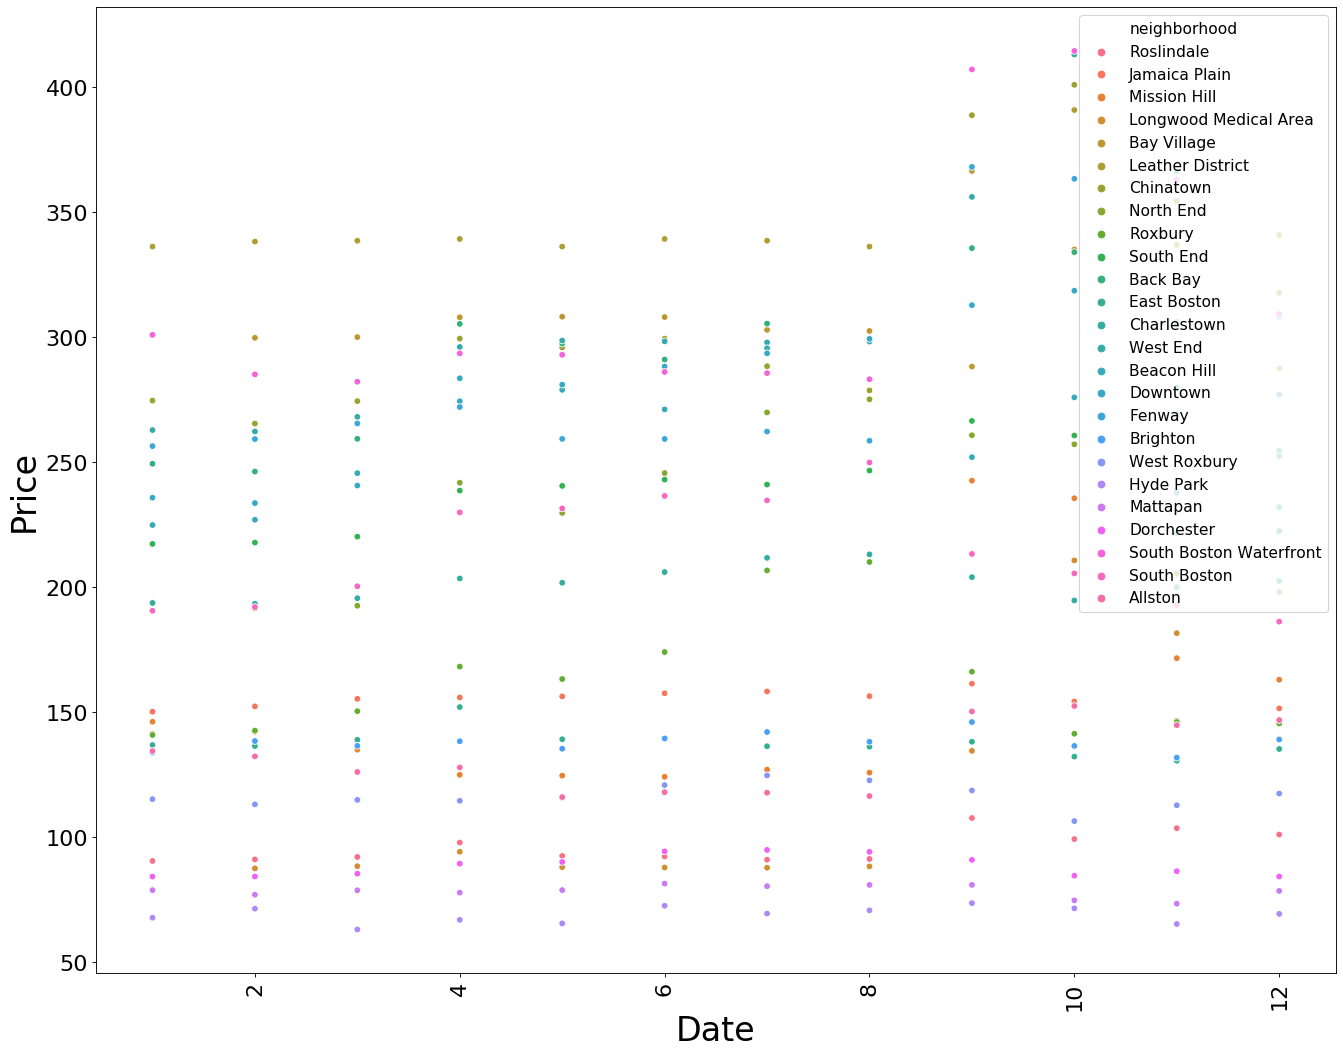

In [49]:
fig = plt.figure(figsize=(20, 16), dpi=80)
sns.scatterplot(x = 'date', y = 'calendar_price', data = grouped, hue = 'neighborhood')
plt.ylabel('Price', fontsize=30)
plt.xlabel('Date', fontsize=30)
plt.tick_params(axis='x', labelsize=20, rotation=90)
plt.tick_params(axis='y', labelsize=20)
plt.legend(fontsize=14);

In [50]:
boston['day_of_year'] = boston['date'].dt.dayofyear

In [51]:
average_calendar_price = []
for day_of_year in tqdm(boston['day_of_year'].unique()):
    df = boston[boston['day_of_year'] == day_of_year]
    df = df['calendar_price'].mean()
    row = (df, day_of_year)
    average_calendar_price.append(row)
average_calendar_price = pd.DataFrame(average_calendar_price, columns = ['average_calendar_price', 'day_of_year'])
boston = boston.merge(average_calendar_price, on='day_of_year')

100%|██████████| 365/365 [00:07<00:00, 48.78it/s]


No handles with labels found to put in legend.


/home/steven/.local/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


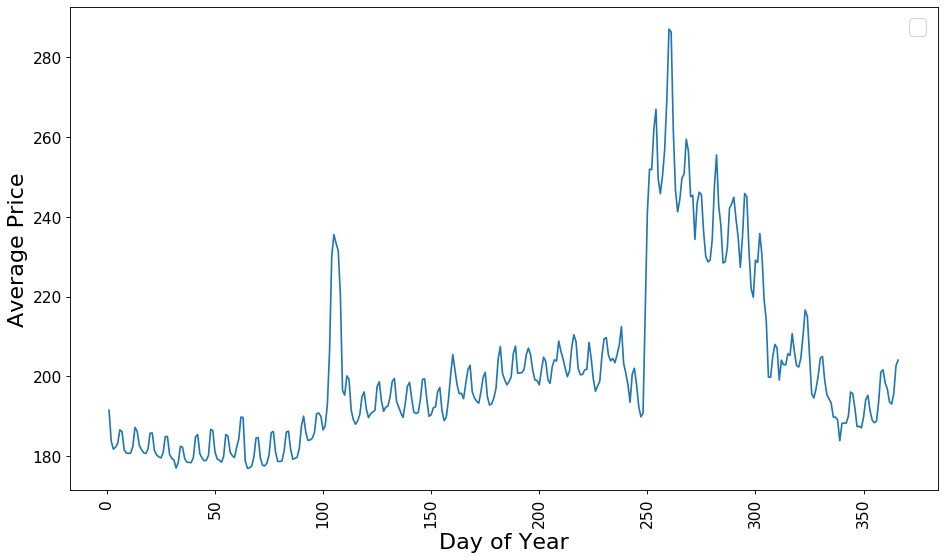

In [52]:
boston_copy_1 = boston.sort_values(by = ['day_of_year'])
fig = plt.figure(figsize=(14, 8), dpi=80)
plt.plot(boston_copy_1['day_of_year'], boston_copy_1['average_calendar_price'])
plt.ylabel('Average Price', fontsize=20)
plt.xlabel('Day of Year', fontsize=20)
plt.tick_params(axis='x', labelsize=14, rotation=90)
plt.tick_params(axis='y', labelsize=14)
plt.legend(fontsize=20)

## Which Neighborhoods are Most Often Booked
Using review_per_month and available columns to determine how often a neighborhood it booked

In [53]:
boston_5 = boston
boston_5['reviews_per_month'] = boston_5['reviews_per_month'].fillna(0)

boston_5['reviews_by_nights'] = boston_5['reviews_per_month']*boston['minimum_nights']

In [54]:
boston_5['reviews_per_month'].mean()

1.5548522030117122

In [55]:
def median_sort_order_with_cutoff(df, sort_column, func_column, new_df_column_1, new_df_column_2, cutoff):
    """Finds median price of each neighborhood and returns sort order based on that price with a cutoff"""
    order = [0,0]
    for x in tqdm(df[sort_column].unique()):
        df_1 = df[df[sort_column] == x]
        median = df_1[func_column].median()
        row = [x, median]
        row = np.array(row)
        order = np.vstack([order, row])
    order = pd.DataFrame(order, columns = [new_df_column_1, new_df_column_2])
    order[new_df_column_2] = order[new_df_column_2].astype(float)
    order = order.drop(order.index[0])
    order = order.sort_values(by = new_df_column_2, ascending = False)
    order = order[order[new_df_column_2]>cutoff]
    sort_order = list(order[new_df_column_1])
    return sort_order

100%|██████████| 25/25 [00:01<00:00, 13.10it/s]
No handles with labels found to put in legend.


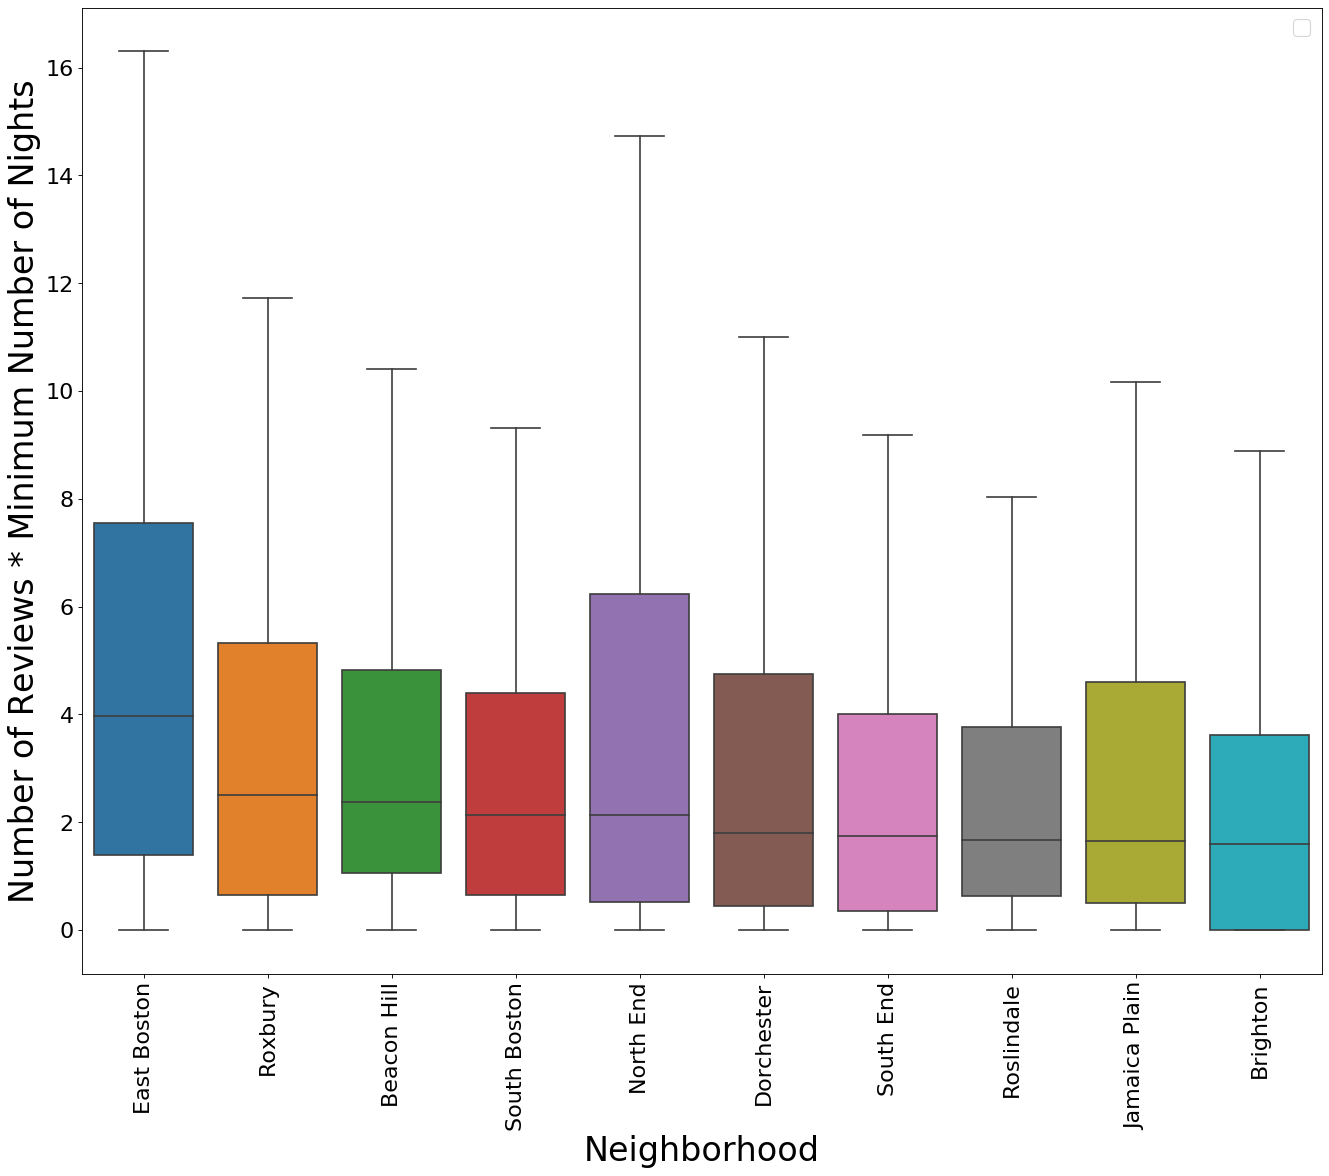

In [56]:
# Compare calendar_prices to the Neighborhood

sort_order = median_sort_order_with_cutoff(boston, 'neighbourhood_cleansed', 'reviews_by_nights', 'neighbourhood_cleansed', 'median_reviews_by_nights', 1.55)

fig = plt.figure(figsize=(20, 16), dpi=80)
sns.boxplot(x = 'neighbourhood_cleansed', y = 'reviews_by_nights', data = boston_5, showfliers = False, order = sort_order)
plt.ylabel('Number of Reviews * Minimum Number of Nights', fontsize=30)
plt.xlabel('Neighborhood', fontsize=30)
plt.tick_params(axis='x', labelsize=20, rotation=90)
plt.tick_params(axis='y', labelsize=20)
plt.legend(fontsize=20);

In [57]:
availability = [0,0]
for listing in tqdm(boston['listing_id'].unique()):
    df = boston[boston['listing_id'] == listing]
    df_1 = df[df['available'] == 'f']
    available = df_1.shape[0]
#     print(available)
    row = [listing, available]
    row = np.array(row)
    availability = np.vstack([availability, row])
availability = pd.DataFrame(availability, columns = ['listing_id', 'unavailable_total'])
availability = availability.drop(availability.index[0])
boston = boston.merge(availability, on='listing_id')

100%|██████████| 3585/3585 [00:15<00:00, 238.58it/s]


In [58]:
boston['day_prop'] = boston['unavailable_total']/365

100%|██████████| 25/25 [00:02<00:00,  9.64it/s]
No handles with labels found to put in legend.


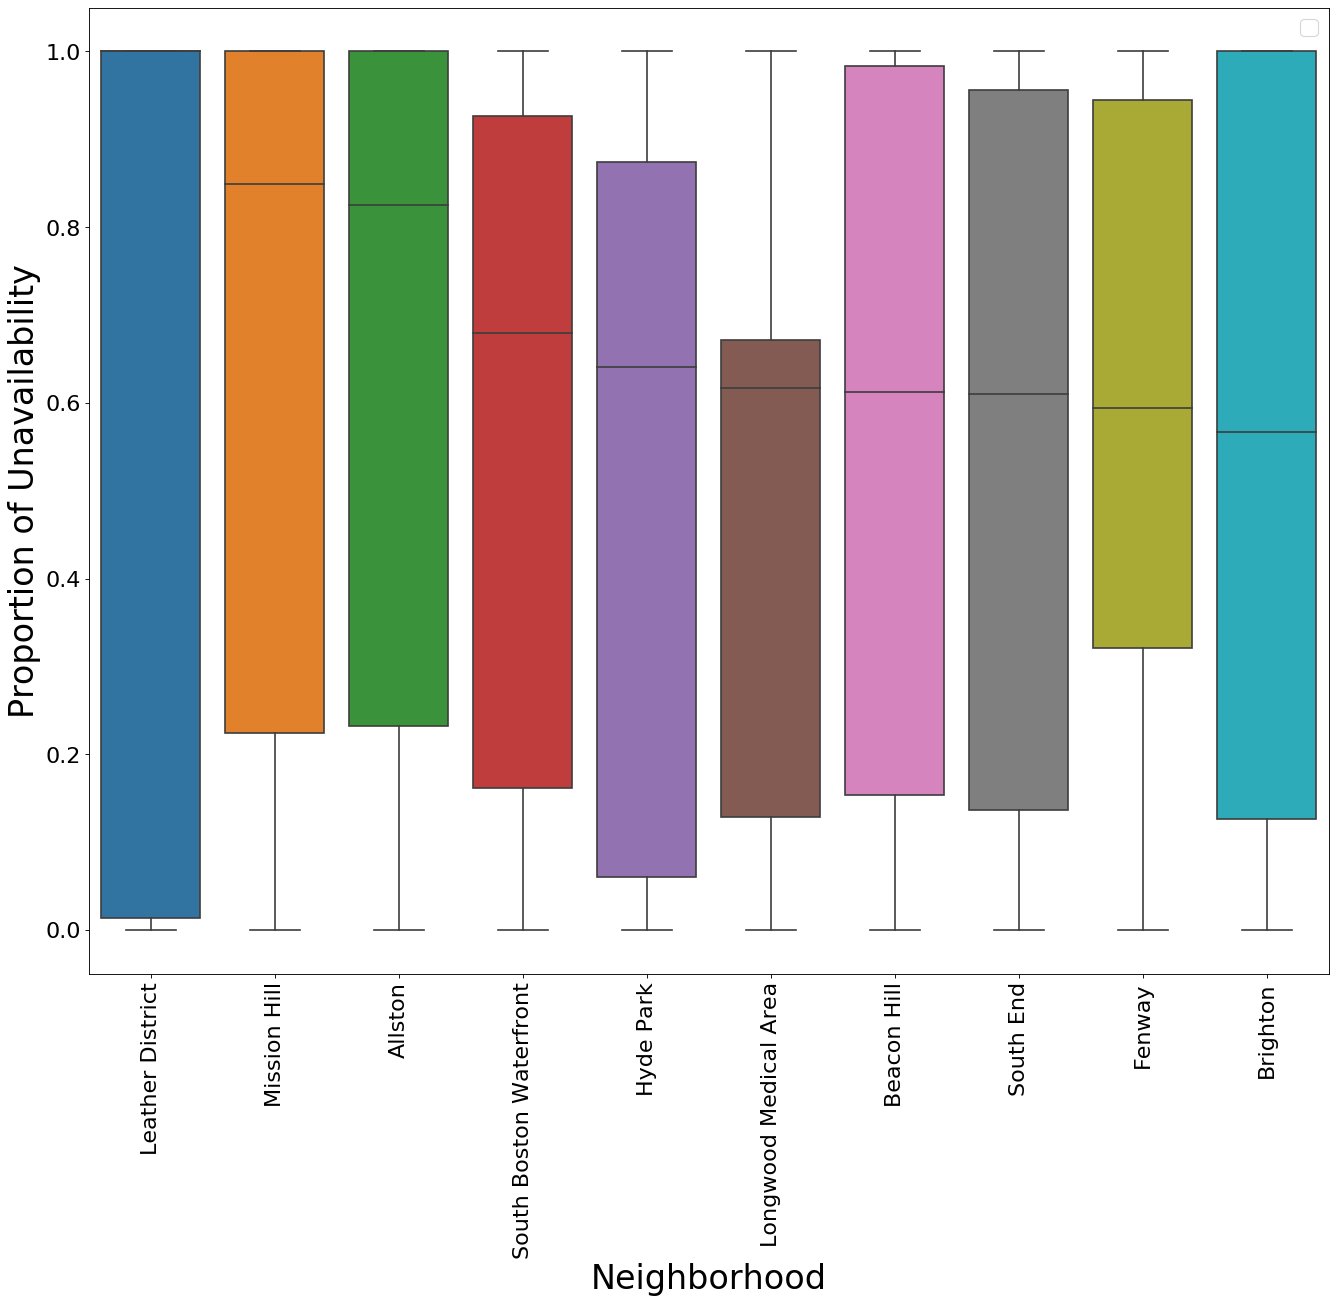

In [59]:
# Compare prices to the Neighborhood

sort_order = median_sort_order_with_cutoff(boston, 'neighbourhood_cleansed', 'day_prop', 'neighbourhood_cleansed', 'median_day_prop', 0.55)


fig = plt.figure(figsize=(20, 16), dpi=80)
sns.boxplot(x = 'neighbourhood_cleansed', y = 'day_prop', data = boston, showfliers = False, order = sort_order)
plt.ylabel('Proportion of Unavailability', fontsize=30)
plt.xlabel('Neighborhood', fontsize=30)
plt.tick_params(axis='x', labelsize=20, rotation=90)
plt.tick_params(axis='y', labelsize=20)
plt.legend(fontsize=20);

In [60]:
prop = []
for day_of_year in tqdm(boston['day_of_year'].unique()):
    df = (boston['available'][(boston['day_of_year'] == day_of_year) & (boston['available']== 'f')].value_counts()[0])/(boston['available'][boston['day_of_year'] == day_of_year].value_counts().sum()).mean()
    row = (df, day_of_year)
    prop.append(row)
prop = pd.DataFrame(prop, columns = ['proportion', 'day_of_year'])
boston = boston.merge(prop, on='day_of_year')

100%|██████████| 365/365 [00:15<00:00, 23.17it/s]


No handles with labels found to put in legend.


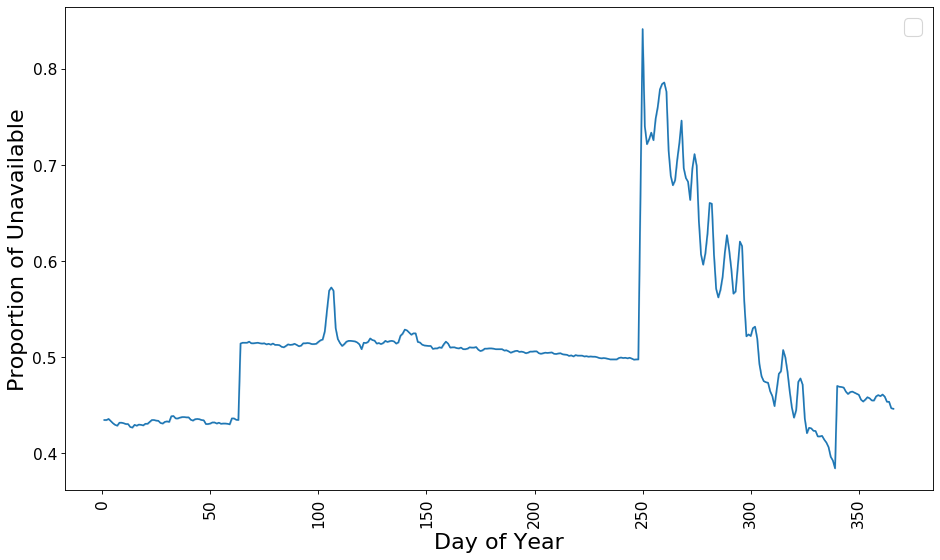

In [61]:
fig = plt.figure(figsize=(14, 8), dpi=80)
sns.lineplot(x = boston['day_of_year'], y = boston['proportion'])
plt.ylabel('Proportion of Unavailable', fontsize=20)
plt.xlabel('Day of Year', fontsize=20)
plt.tick_params(axis='x', labelsize=14, rotation=90)
plt.tick_params(axis='y', labelsize=14)
plt.legend(fontsize=20)